In [2]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

import cv2

import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later
import glob
import pandas as pd
import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import *
from AnaUtil import *
from bisect import bisect_left
from tqdm import tqdm
import datetime as dt
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 16
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 24

In [3]:
%matplotlib notebook

In [4]:
def gaussian(x,params=list):
    norm = (1/((1/2*params[2])*np.sqrt(np.pi * 2)))
    return params[0] * norm * np.exp(-(np.subtract(x,params[1])**2/(2*params[2]**2)))+params[3]


In [5]:
def gaussian_bead_pos_fit(img,axis=0,low_x_lim=500,up_x_lim=800,low_y_lim=420,up_y_lim=550,upper_area=300,up_lim_width=20):

    
    
    def chisquare_1d(function, functionparams, data_x, data_y,data_y_error):
        chisquarevalue=np.sum(np.power(np.divide(np.subtract(function(data_x,functionparams),data_y),data_y_error),2))
        ndf = len(data_y)-len(functionparams)
        #print(ndf)
        return (chisquarevalue, ndf)
    
    def chisquare_gaussian(area,mean,sigma,constant):
        return chisquare_1d(function=gaussian,functionparams=[area,mean,sigma,constant],data_x=data_x,data_y=data_y,data_y_error=data_y_error)[0]
   

    area=0
    mean=0
    sigma=0
    constant=0
    
    if(axis==0):
        img2 = img.transpose()
        data_x = range(1024) # give x data
        data_y = np.mean(img2[low_x_lim:up_x_lim],axis=0) # give y data 
        data_y_error = np.sqrt(data_y) # give y uncertainty
        low_lim_mean = low_y_lim
        up_lim_mean = up_y_lim
        
    if(axis==1):
        data_x = range(1280) # give x data
        data_y = np.mean(img[low_y_lim:up_y_lim],axis=0) # give y data 
        data_y_error = np.sqrt(data_y) # give y uncertainty
        low_lim_mean = low_x_lim
        up_lim_mean = up_x_lim
        
        
    m=Minuit(chisquare_gaussian, 
             area = 100, # set start parameter
             error_area = 1,
             limit_area= (0,upper_area), # if you want to limit things
             #fix_area = "True", # you can also fix it
             mean = np.argmax(data_y),
             error_mean = 1,
             #fix_mean = "False",
             limit_mean = (low_lim_mean,up_lim_mean),
             sigma = 15,
             error_sigma = 1,
             limit_sigma=(0,up_lim_width),
             constant = 10,
             error_constant = 1,
             #fix_constant=0,
             errordef = 1,
             print_level=0)
    #print('Now proceed with the fit.')
    m.migrad(ncall=500000)
    #m.minos(), if you need fancy mapping
    chisquare=m.fval
    
    return m.values['mean']#,m

In [43]:
def height_analysis_wrapper(dirname,file_prefix):
    
    pos_y = [] 
    pos_z =[]
    pos_z_alt =[]
    maximum_intensity =[]
    max_z_1d_zoom = []
    
    files = []
    [files.append(file_) for file_ in os.listdir(dirname) if file_.startswith(file_prefix) if file_.endswith('.npy')]

    for j in tqdm(range(len(files))):
        img = np.load(dirname + file_prefix + "%d.npy" %(j))
        
        img2 = img.transpose()
        
        max_z_1d_zoom.append(np.argmax(np.mean(img2[600:700],axis=0)))    
        maximum_intensity.append(np.max(img))

        pos_z.append(gaussian_bead_pos_fit(img,axis=0))#,low_x_lim=550,up_x_lim=750,low_y_lim=420,up_y_lim=550,upper_area=1500,up_lim_width=10))
        pos_y.append(gaussian_bead_pos_fit(img,axis=1))#,low_x_lim=550,up_x_lim=750,low_y_lim=420,up_y_lim=550,upper_area=1500,up_lim_width=10))    
        pos_z_alt.append(gaussian_bead_pos_fit(img,axis=0,up_lim_width=10))#,low_x_lim=550,up_x_lim=750,low_y_lim=420,up_y_lim=550,upper_area=1500,up_lim_width=10))    

        #pos.append(gaussian_bead_pos_fit(img2))
    return pos_z,pos_y,pos_z_alt,max_z_1d_zoom, maximum_intensity

In [9]:
def pixel_to_um(pixel,axis="z"):
    if(axis=="z"):um = 1024*0.46-np.multiply(pixel,0.46)
    elif(axis=="y"):um = 1280*0.46-np.multiply(pixel,0.46) 
    return um

In [91]:
pos_lists = height_analysis_wrapper(dirname="/data/new_trap/20200210/Bead2/Shaking/Shaking384/Pictures_7/",file_prefix ="Shaking7_")

100%|██████████| 5000/5000 [07:26<00:00, 12.19it/s]


<IPython.core.display.Javascript object>


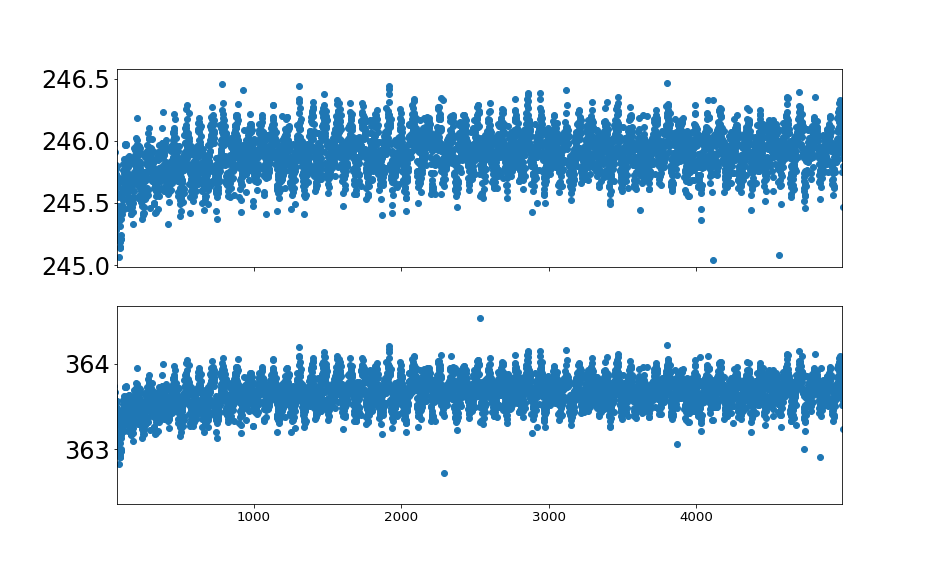

In [95]:
_,ax = plt.subplots(2,1, figsize=(13,8), sharex=True)
ax[0].scatter(range(len(pos_lists[0])), pixel_to_um(pos_lists[0]))
# ax[0].scatter(range(len(pos_lists[0])), pos_lists[4])
ax[1].scatter(range(len(pos_lists[0])), pixel_to_um(pos_lists[2],axis="y"))

In [82]:
firname = '/data/new_trap/20200210/Bead2/Shaking/Shaking387/'
bdf_data = load_dir_sorted(dirname=firname, file_prefix='Shaking0')

800  files in folder
500  files loaded


<IPython.core.display.Javascript object>


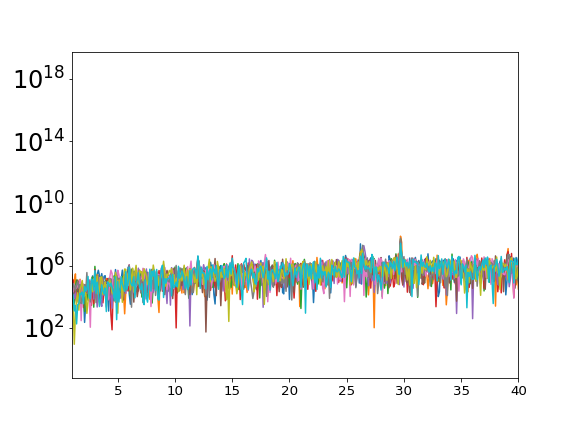

[(1, 40)]

In [83]:
_,ax = plt.subplots(figsize=(8,6))
[ax.semilogy(*bb.psd2('z')) for bb in bdf_data[::50]]
ax.set(xlim=(1,40))

In [49]:
pos_listsZ = height_analysis_wrapper(dirname="/data/new_trap/20200226/Bead1/Response/Pictures/",file_prefix ="Discharge_")

100%|██████████| 301/301 [00:23<00:00, 12.86it/s]


In [37]:
bdf = BeadDataFile.BeadDataFile(fname='/data/new_trap/20200226/Bead1/TransFunc/TransFunc_X_1.h5')

No height data
No cantilever data
Error loading spinning data


In [50]:
pixel_to_um(pos_listsZ[0])

array([250.00904093, 249.54678686, 249.86204592, 250.11730852,
       249.67477644, 249.08215915, 249.77727401, 249.98061589,
       249.44673233, 249.46984158, 249.34411897, 250.02309544,
       248.85527872, 248.7630554 , 249.18987765, 249.82781199,
       250.42157634, 249.49882497, 249.42300877, 249.47552451,
       249.35246544, 250.01881887, 249.96858198, 249.72034443,
       250.07310584, 249.90034825, 250.12588182, 249.31030649,
       249.26685398, 250.07809699, 249.47208301, 249.83406162,
       249.2310754 , 249.65167459, 249.80813279, 248.4233985 ,
       251.13560592, 248.76073283, 249.50536839, 248.83788729,
       249.02815315, 249.41866017, 249.47257822, 248.52849742,
       248.55454164, 249.22474679, 249.34917203, 248.86746725,
       249.21706066, 249.19107609, 249.65184784, 249.36319133,
       249.33377064, 249.5871772 , 249.63554382, 248.81291788,
       249.82366109, 249.48331142, 249.2810903 , 248.66896927,
       248.72496764, 248.86217884, 249.5509051 , 248.83

<IPython.core.display.Javascript object>


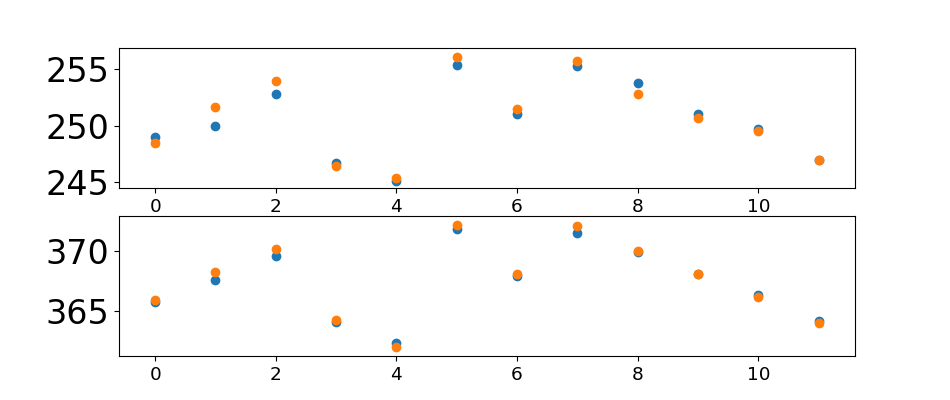

In [36]:
_,ax = plt.subplots(2,1,figsize=(9.5,4))
ax[0].scatter(range(12),pixel_to_um(pos_listsX[0]))
ax[0].scatter(range(12),pixel_to_um(pos_listsZ[0]))

ax[1].scatter(range(12),pixel_to_um(pos_listsX[2], axis='y'))
ax[1].scatter(range(12),pixel_to_um(pos_listsZ[2], axis='y'))